In [1]:
# dependencies
import matplotlib
from matplotlib import style
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
import datetime as dt

# Python SQL tools
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Set plot style
style.use('fivethirtyeight')

In [2]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()
#engine.table_names()

['measurements', 'stations']

In [5]:
# Save references to each table
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [6]:
# Create a session for Python to the DB
session = Session(engine)

In [7]:
# The the last 12 months of precipitation data

# Get the data from a year ago to today
previous_year = dt.date.today() - dt.timedelta(days=365)

# Query the database for the requested data
one_year_precip = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= previous_year).all()

# Load the query results into a Pandas DataFrame and set the index to the date column.
precip_df = pd.DataFrame(one_year_precip, columns=['date', 'precipitation'])
precip_df.set_index(precip_df['date'], inplace=True)

# Plot the results using the DataFrame `plot` method.
precip_df.plot(x_compat=True)
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [8]:
# Use Pandas to print the summary statistics for the precipitation data.
precip_df.describe()

,precipitation
count,676.000000
mean,0.138772
std,0.392622
min,0.000000
25%,0.000000
50%,0.020000
75%,0.110000
max,6.250000


In [9]:
# Design a query to calculate the total number of stations.
session.query(func.count(Stations.name)).all()

[(9)]

In [10]:
# Design a query to find the most active stations
# List the stations and observation counts in descending order
session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [11]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs)
one_year_temps = session.query(Measurements.date, Measurements.station, Measurements.tobs).filter(Measurements.date >= previous_year).all()

# Load the query results into a Pandas DataFrame and set the index to the date column.
temp_df = pd.DataFrame(one_year_temps, columns=['date', 'station', 'tobs'])
temp_df.set_index(temp_df['date'], inplace=True)
temp_df.head()

,date,station,tobs
date,,,
2017-04-27,2017-04-27,USC00519397,78.0
2017-04-28,2017-04-28,USC00519397,76.0
2017-04-29,2017-04-29,USC00519397,72.0
2017-04-30,2017-04-30,USC00519397,63.0
2017-05-01,2017-05-01,USC00519397,75.0


In [12]:
# Determine the station with the highest number of measurements for the past year
# This is to show the measurement counts by station and determine the highest station using code
# This is for verification purposes only, see code in cell below
print(temp_df.groupby('station').count())
temp_df.groupby('station').count().tobs.idxmax()

             date  tobs
station                
USC00513117    96    96
USC00514830   100   100
USC00516128   112   112
USC00517948    39    39
USC00519281   105   105
USC00519397   114   114
USC00519523   110   110


'USC00519397'

In [13]:
# Determine the station with the highest number of measurements for the past year
# Create a DataFrame to store the measurements over the past year for the station with the highest count of measurements
high_count_station = temp_df.groupby('station').count().tobs.idxmax()
print(high_count_station)
high_count_station_df = temp_df[temp_df['station']==high_count_station]
high_count_station_df.head()

USC00519397


,date,station,tobs
date,,,
2017-04-27,2017-04-27,USC00519397,78.0
2017-04-28,2017-04-28,USC00519397,76.0
2017-04-29,2017-04-29,USC00519397,72.0
2017-04-30,2017-04-30,USC00519397,63.0
2017-05-01,2017-05-01,USC00519397,75.0


In [14]:
# Plot the results as a histogram with `bins=12`
high_count_station_df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [15]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

start_date = input("What is the start date (format as YYYY-MM-DD)? ")
end_date = input("What is the end date (format as YYYY-MM-DD)? ")

print(calc_temps(start_date, end_date))

What is the start date (format as YYYY-MM-DD)? 2012-04-05
What is the end date (format as YYYY-MM-DD)? 2012-04-12
[(64.0, 70.42622950819673, 77.0)]


In [17]:
# Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year 

prev_year_start_date = dt.date(2012, 4, 5) - dt.timedelta(days=365)
prev_year_end_date = dt.date(2012, 4, 12) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start_date.strftime("%Y-%m-%d"), prev_year_end_date.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

64.0 71.46969696969697 77.0


<IPython.core.display.Javascript object>


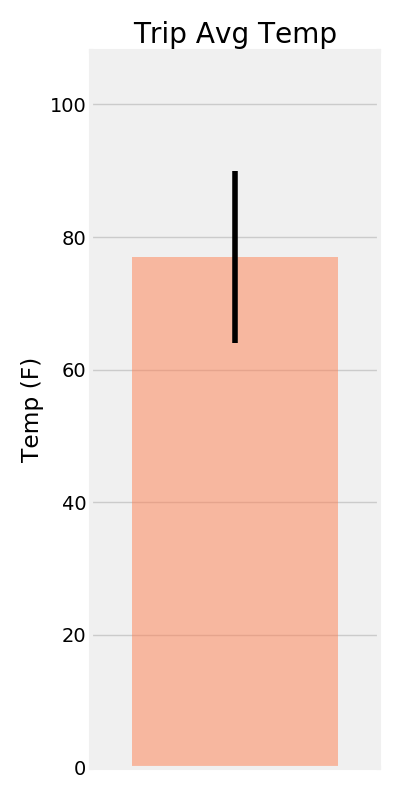

In [18]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.show()